<a href="https://colab.research.google.com/github/ssudhakar165/colab/blob/main/retina_detecector_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/facebookresearch/detectron2.git
!pip install pyyaml==5.2

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-h9xuxl6n
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-h9xuxl6n
     |████████████████████████████████| 2.2MB 8.5MB/s 
  Created wheel for detectron2: filename=detectron2-0.3-cp36-cp36m-linux_x86_64.whl size=5490796 sha256=9fa5fe8149981c395cc39dbe5aa7aa7e7bdc0006ebdc4c12228d888d28a2996e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mfn40llw/wheels/33/ac/bb/5ef90585c21c67e2f0b6aae55ec6b43017ad57af33d5f4c339
  Created wheel for fvcore: filename=fvcore-0.1.2.post20210115-cp36-none-any.whl size=40892 sha256=5e400d6cc161f875238110dee86f95ee4551181bb7c2dc938a2616b2cfa57b03
  Stored in directory: /root/.cache/pip/wheels/cc/0f/bc/fb742771f4a877f1211dd6ed36283b0db9c0ceb2b409b4a039
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10508 sha256=97f8dc7c40339cc6b62d02c849e2befa582be07264f2eb8d76cb5e208674f006
  Stored in directory: /ro

     |████████████████████████████████| 266kB 7.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.2-cp36-cp36m-linux_x86_64.whl size=44210 sha256=f963af3bc26a35d19472a8622df6ab836fa715ed0c8200b81a77e3db9a38f457
  Stored in directory: /root/.cache/pip/wheels/54/b7/c7/2ada654ee54483c9329871665aaf4a6056c3ce36f29cf66e67
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os

import cv2
import random
from PIL import Image
from google.colab.patches import cv2_imshow

In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog
## loading pretrained weights
from detectron2 import model_zoo
## getting model config file
from detectron2.config import get_cfg
## for training and prediction
from detectron2.engine import DefaultPredictor, DefaultTrainer 
## visualizing data
from detectron2.utils.visualizer import Visualizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/My\ Drive/blood.zip


Archive:  /content/drive/My Drive/blood.zip
   creating: images/
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/101.jpg          
  inflating: images/102.jpg          
  inflating: images/103.jpg          
  inflating: images/104.jpg          
  inflating: images/105.jpg          
  inflating: images/106.jpg          
  inflating: images/107.jpg          
  inflating: images/108.jpg          
  inflating: images/109.jpg          
  inflating: images/11.jpg           
  inflating: images/110.jpg          
  inflating: images/111.jpg          
  inflating: images/112.jpg          
  inflating: images/113.jpg          
  inflating: images/114.jpg          
  inflating: images/115.jpg          
  inflating: images/116.jpg          
  inflating: images/117.jpg          
  inflating: images/118.jpg          
  inflating: images/119.jpg          
  inflating: images/12.

In [5]:
train= pd.read_csv('train.csv')

In [6]:
train.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,1.jpg,RBC,68,165,154,249
1,1.jpg,RBC,1,66,145,260
2,1.jpg,RBC,207,334,160,270
3,1.jpg,RBC,435,540,347,437
4,1.jpg,RBC,535,639,356,464


In [7]:
train.shape

(3423, 6)

In [8]:
train['cell_type']= train['cell_type'].replace({'RBC':0,'WBC': 1})

In [9]:
train.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,1.jpg,0,68,165,154,249
1,1.jpg,0,1,66,145,260
2,1.jpg,0,207,334,160,270
3,1.jpg,0,435,540,347,437
4,1.jpg,0,535,639,356,464


In [10]:
train= train.loc[ (train['cell_type']==0)|(train['cell_type']==1)]

In [11]:
train.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,1.jpg,0,68,165,154,249
1,1.jpg,0,1,66,145,260
2,1.jpg,0,207,334,160,270
3,1.jpg,0,435,540,347,437
4,1.jpg,0,535,639,356,464


In [12]:

train.shape

(3171, 6)

In [13]:
def bloodCellDet_Converter():
    dataset = []
    for img_name in train.image_names.unique():

      ## empty dict
        det2_dict = {}
        det2_dict['file_name'] = 'images/' + img_name

        ## image width and height 
        det2_dict['width'], det2_dict['height'] = Image.open('images/' + img_name).size
        det2_dict['image_id'] = img_name.split('.')[0]

        ## making annotations list
        annotations = []
        bbox_instances = train[train.image_names == img_name][['xmin', 'ymin', 'xmax', 'ymax']].values.astype('float').tolist()
        category_instances = train[train.image_names == img_name][['cell_type']].values.astype('int').tolist()


        for idx in range(len(bbox_instances)):
            annot = {}
            annot['bbox'] = bbox_instances[idx]
            annot['bbox_mode'] = 0 
            annot['category_id'] = int(category_instances[idx][0])
            annotations.append(annot)

        det2_dict['annotations'] = annotations

        dataset.append(det2_dict)

    return dataset
   

In [14]:
DatasetCatalog.register("bloodCellDet_datase", bloodCellDet_Converter)
bloodCellDet_metadata = MetadataCatalog.get("bloodCellDet_datase").set(thing_classes=["RBC", "WBC"])

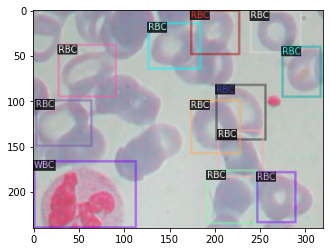

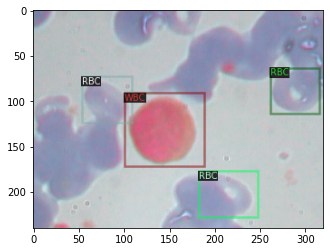

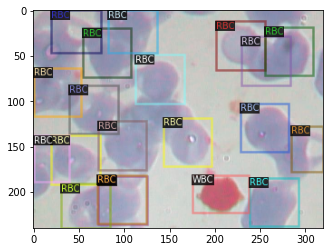

In [15]:
for d in random.sample(bloodCellDet_Converter(), 3):

    img = cv2.imread(d["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=bloodCellDet_metadata, scale=0.5)

    vis = visualizer.draw_dataset_dict(d)
    
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml")) 

cfg.DATASETS.TRAIN = ("bloodCellDet_datase",) 
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 1000  
cfg.MODEL.RETINANET.NUM_CLASSES = 2 

os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
trainer = DefaultTrainer(cfg)        
trainer.resume_or_load(resume = True) 
trainer.train()

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[01/20 13:27:51 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_bfca0b.pkl: 152MB [02:30, 1.01MB/s]                          
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (18, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.


[01/20 13:30:28 d2.engine.train_loop]: Starting training from iteration 0
[01/20 13:30:52 d2.utils.events]:  eta: 0:19:42  iter: 19  total_loss: 2.477  loss_cls: 1.843  loss_box_reg: 0.656  time: 1.2026  data_time: 0.0153  lr: 4.9953e-06  max_mem: 1903M
[01/20 13:31:16 d2.utils.events]:  eta: 0:18:59  iter: 39  total_loss: 1.591  loss_cls: 1.216  loss_box_reg: 0.349  time: 1.1880  data_time: 0.0077  lr: 9.9902e-06  max_mem: 1903M
[01/20 13:31:39 d2.utils.events]:  eta: 0:18:13  iter: 59  total_loss: 1.601  loss_cls: 1.282  loss_box_reg: 0.3338  time: 1.1857  data_time: 0.0058  lr: 1.4985e-05  max_mem: 1903M
[01/20 13:32:04 d2.utils.events]:  eta: 0:18:31  iter: 79  total_loss: 1.55  loss_cls: 1.15  loss_box_reg: 0.327  time: 1.1930  data_time: 0.0064  lr: 1.998e-05  max_mem: 1916M
[01/20 13:32:27 d2.utils.events]:  eta: 0:18:02  iter: 99  total_loss: 1.381  loss_cls: 1.129  loss_box_reg: 0.2933  time: 1.1870  data_time: 0.0065  lr: 2.4975e-05  max_mem: 1916M
[01/20 13:32:51 d2.utils.ev

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7    
cfg.DATASETS.TEST = ("bloodCellDet_dataset", ) 
predictor = DefaultPredictor(cfg) 


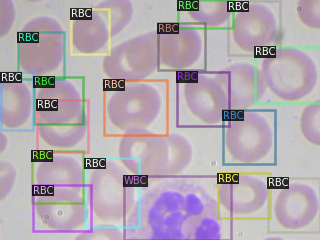

In [ ]:
img = bloodCellDet_Converter()[0]
d = (bloodCellDet_Converter()[0]).get('file_name')
im = cv2.imread(d)
v = Visualizer(im[:, :, ::-1],
                metadata=bloodCellDet_metadata, 
                scale=0.5
)
v = v.draw_dataset_dict(img)
cv2_imshow(v.get_image()[:, :, ::-1])

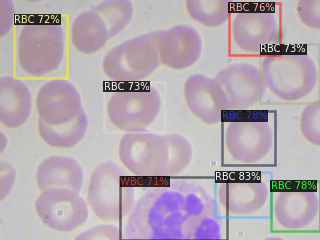

In [ ]:
d = (bloodCellDet_Converter()[0]).get('file_name')
im = cv2.imread(d)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=bloodCellDet_metadata, 
                scale=0.5
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Retina net **101**

In [16]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml")) 

cfg.DATASETS.TRAIN = ("bloodCellDet_datase",) 
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 1000  
cfg.MODEL.RETINANET.NUM_CLASSES = 2 

os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
trainer = DefaultTrainer(cfg)        
trainer.resume_or_load(resume = True) 
trainer.train()

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[01/20 13:59:17 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_971ab9.pkl: 228MB [00:03, 64.2MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (18, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.


[01/20 13:59:27 d2.engine.train_loop]: Starting training from iteration 0
[01/20 13:59:40 d2.utils.events]:  eta: 0:09:01  iter: 19  total_loss: 2.478  loss_cls: 1.777  loss_box_reg: 0.7268  time: 0.5877  data_time: 0.0138  lr: 4.9953e-06  max_mem: 2791M
[01/20 13:59:51 d2.utils.events]:  eta: 0:08:52  iter: 39  total_loss: 1.522  loss_cls: 1.119  loss_box_reg: 0.3437  time: 0.5759  data_time: 0.0055  lr: 9.9902e-06  max_mem: 2804M
[01/20 14:00:02 d2.utils.events]:  eta: 0:08:42  iter: 59  total_loss: 1.471  loss_cls: 1.087  loss_box_reg: 0.353  time: 0.5742  data_time: 0.0055  lr: 1.4985e-05  max_mem: 2804M
[01/20 14:00:14 d2.utils.events]:  eta: 0:08:32  iter: 79  total_loss: 1.353  loss_cls: 1.026  loss_box_reg: 0.299  time: 0.5742  data_time: 0.0048  lr: 1.998e-05  max_mem: 2804M
[01/20 14:00:26 d2.utils.events]:  eta: 0:08:29  iter: 99  total_loss: 1.302  loss_cls: 1.006  loss_box_reg: 0.2924  time: 0.5793  data_time: 0.0049  lr: 2.4975e-05  max_mem: 2812M
[01/20 14:00:38 d2.utils

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7    
cfg.DATASETS.TEST = ("bloodCellDet_dataset", ) 
predictor = DefaultPredictor(cfg) 


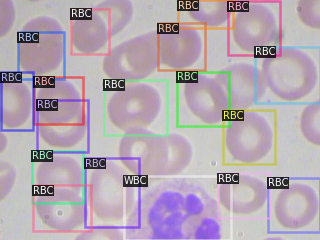

In [18]:
img = bloodCellDet_Converter()[0]
d = (bloodCellDet_Converter()[0]).get('file_name')
im = cv2.imread(d)
v = Visualizer(im[:, :, ::-1],
                metadata=bloodCellDet_metadata, 
                scale=0.5
)
v = v.draw_dataset_dict(img)
cv2_imshow(v.get_image()[:, :, ::-1])

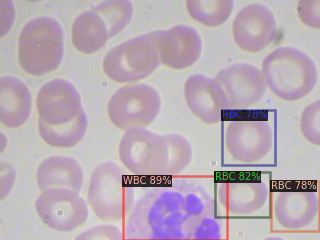

In [19]:
d = (bloodCellDet_Converter()[0]).get('file_name')
im = cv2.imread(d)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=bloodCellDet_metadata, 
                scale=0.5
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

% WBC is 89% in resnet 101 and 71% in resnet 50== huge diff


%RBC  is 82, 78, 78 perecentages in resnet 101 and  83,78, 78 i resnet 50
I think focu; loss makes WBC prominent % 